### Load Data

In [6]:
import pandas as pd
columnas = ["mbti","clean_text"]
data = pd.read_csv("../data/data_spanish/data_spanish.csv",usecols=columnas)
data["mbti"] = data["mbti"].apply(lambda x: x.lower())

a = data["clean_text"].apply(lambda x: len(x.split()))
filtro = a[(a>2500)&(a<10000)].index
data = data.iloc[filtro]

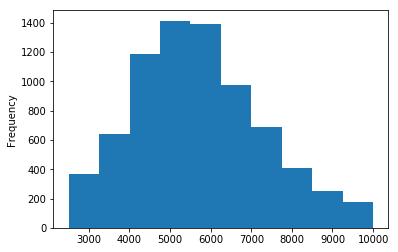

In [8]:
a = data["clean_text"].apply(lambda x: len(x.split()))
a.plot(kind="hist");

### Code data

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

max_len = 1000

#..........................................................................

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["clean_text"])
print("Tokenizer Ready")

min_frequency = 10
remove_words = [w for w,c in tokenizer.word_counts.items() if c <= min_frequency]
for word in remove_words:
    del tokenizer.word_index[word]
    del tokenizer.word_docs[word]
    del tokenizer.word_counts[word]
print(f"Removed {len(remove_words)} words")

# Code
X_seq  = tokenizer.texts_to_sequences(data["clean_text"]) 

#Padding
X_seq  = pad_sequences(X_seq, maxlen=max_len)

vocab_shape=len(tokenizer.word_index) +1
print(f"Vocabulary: {vocab_shape}")

#..........................................................................

# Code Y 
from keras.utils import to_categorical
types = data["mbti"].unique()
Y = data["mbti"].apply(lambda x: np.where(types==x)[0][0])
Y= to_categorical(Y)

In [9]:
import sys
sys.path.append('../Utilities/')
from LIWC.LIWC_ES import LIWC_SPANISH
X_LIWC = LIWC_SPANISH(data["clean_text"])

In [10]:
X_LIWC.head()

,Funct,TotPron,PronPer,Yo,Nosotro,TuUtd,ElElla,Ellos,PronImp,Articulo,...,Trabajo,Logro,Placer,Hogar,Dinero,Relig,Muerte,Asentir,NoFluen,Relleno
0,0.412001,0.130845,0.076259,0.002408,0.005017,0.007626,0.066627,0.024483,0.054586,0.092314,...,0.026490,0.024684,0.006221,0.002810,0.010235,0.002408,0.001003,0.003612,0.000000,0.0
1,0.412649,0.163118,0.108641,0.054790,0.000313,0.013776,0.040701,0.010958,0.054477,0.061365,...,0.017220,0.014715,0.007514,0.001252,0.005322,0.001565,0.000313,0.002505,0.001565,0.0
2,0.459995,0.156243,0.095114,0.030210,0.003540,0.014515,0.050861,0.020887,0.061128,0.076587,...,0.017111,0.019707,0.011801,0.007435,0.005428,0.002478,0.001652,0.003186,0.000000,0.0
3,0.401235,0.131987,0.082567,0.038572,0.000151,0.004821,0.040982,0.010246,0.049420,0.070815,...,0.012204,0.014163,0.012506,0.004369,0.008890,0.001657,0.003616,0.005424,0.000000,0.0
4,0.483333,0.188415,0.121138,0.031098,0.003252,0.040447,0.050407,0.012398,0.067276,0.064837,...,0.018089,0.029675,0.009146,0.003455,0.003049,0.002439,0.000407,0.004675,0.000000,0.0


### Cargar, filtrar y guardar embeddings:

In [9]:
import numpy as np
from tqdm.notebook import tqdm

ruta = '../Utilities/glove300spanish.vec'
def load_embeddings(ruta):
    f = open(ruta,'r', encoding="utf8")
    glove = {}
    for line in tqdm(f):
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        glove[word] = wordEmbedding
    return glove

embeddings_index = load_embeddings(ruta)

In [27]:
def filter_embeddings(vocab_shape,embeddings_index):
    embedding_matrix = np.zeros((vocab_shape,300))
    N = len(tokenizer.word_index.items())
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = filter_embeddings(vocab_shape,embeddings_index)


In [29]:
import pickle 

with open ("embedding_weights_spanish.pkl","wb") as f:
    pickle.dump(embedding_matrix,f)


### Load Embeddings:

In [19]:
import pickle
embedding_matrix = pickle.load(open("embedding_weights_spanish.pkl", "rb"))

# Model

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Texto (InputLayer)              (None, 10000)        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 10000, 300)   47909400    Texto[0][0]                      
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 10000, 300)   0           embedding_5[0][0]                
__________________________________________________________________________________________________
CONV1D1 (Conv1D)                (None, 10000, 128)   38528       spatial_dropout1d_5[0][0]        
____________________________________________________________________________________________

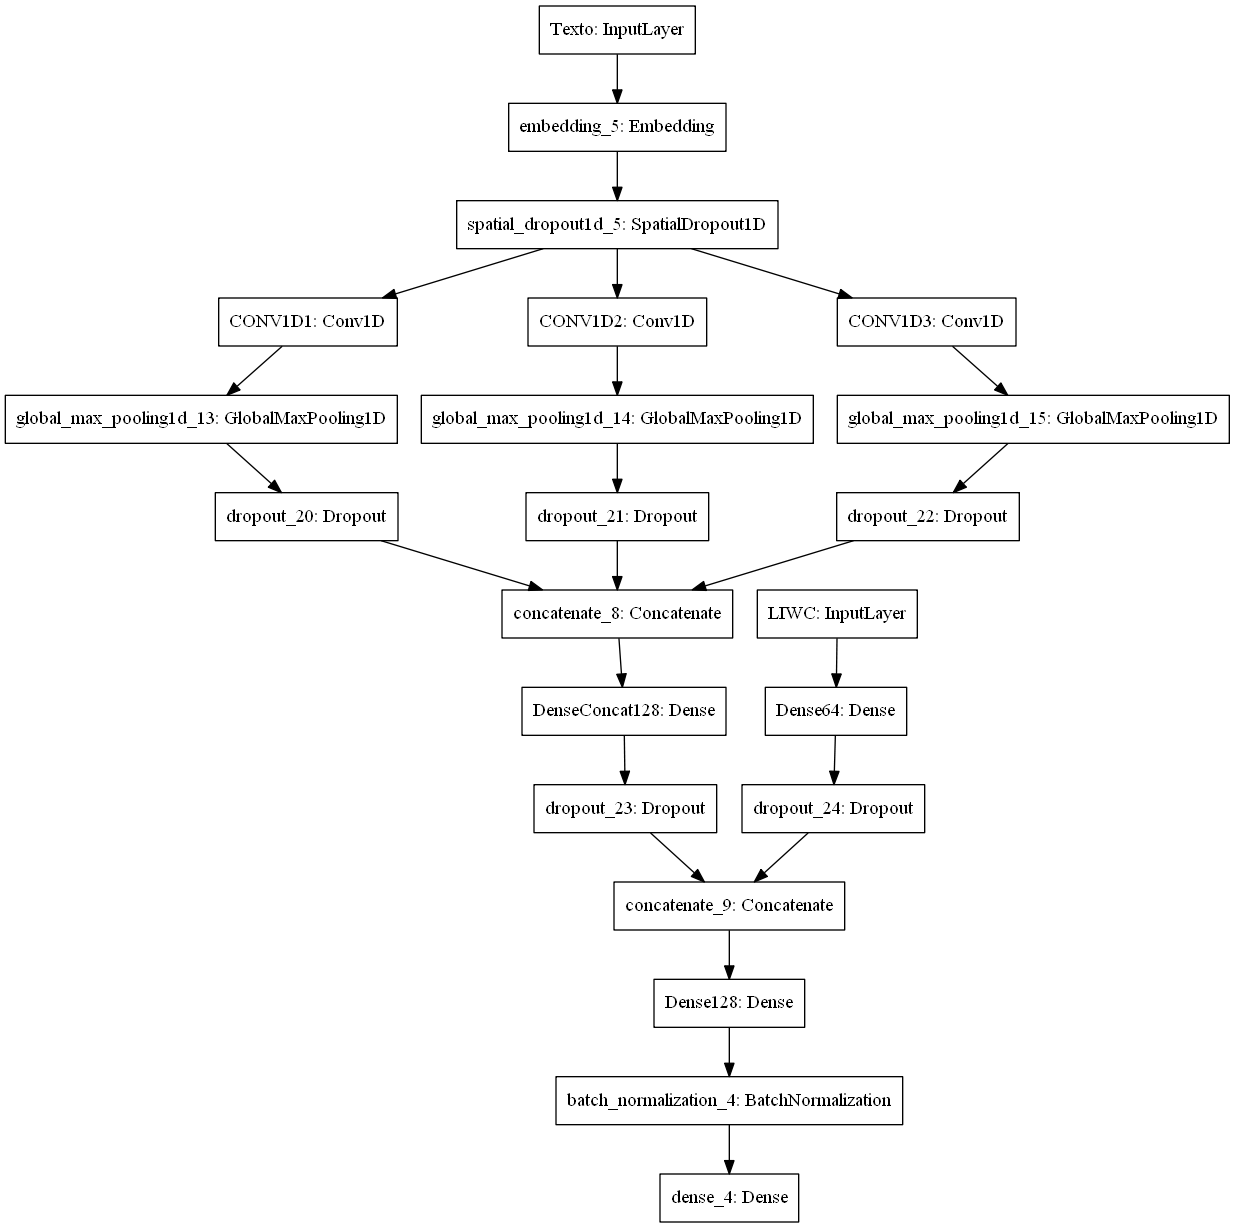

In [20]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate,  BatchNormalization, SpatialDropout1D, Dropout
from keras.utils import plot_model
from keras.callbacks import EarlyStopping


filter_sizes = [1,2,3]
num_filters = 128
embed_shape = 300
dropout = 0.1
dense_neurons = 128

#Entrada
entrada = Input(shape=(max_len,), name="Texto")
x = Embedding(vocab_shape, embed_shape, weights=[embedding_matrix], trainable=False)(entrada)
x = SpatialDropout1D(dropout)(x)


# BRANCH 1
x1 = Conv1D(num_filters , filter_sizes[0], activation="relu", name="CONV1D1")(x)
x1 = GlobalMaxPooling1D()(x1)
x1 = Dropout(dropout)(x1)

# BRANCH 2
x2 = Conv1D(num_filters , filter_sizes[1], activation="relu", name="CONV1D2")(x)
x2 = GlobalMaxPooling1D()(x2)
x2 = Dropout(dropout)(x2)

# BRANCH 3
x3 = Conv1D(num_filters , filter_sizes[2], activation="relu", name="CONV1D3")(x)
x3 = GlobalMaxPooling1D()(x3)
x3 = Dropout(dropout)(x3)


#First concat
c1 = Concatenate()([x1,x2,x3])  
c1 = Dense(dense_neurons,name="DenseConcat128", activation="relu")(c1)
c1 = Dropout(dropout)(c1)


#Entrada2 (LIWC)
entrada2 = Input(shape=(X_LIWC.shape[1],),name="LIWC")
xe2 = Dense(64, name="Dense64")(entrada2)
xe2 = Dropout(dropout)(xe2)

#Second concat
x = Concatenate()([c1,xe2])
x = Dense(128, name="Dense128")(x)
x = BatchNormalization()(x)
salida = Dense(16, activation="softmax")(x)


model = Model(inputs=[entrada,entrada2], outputs=salida)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callbacks = EarlyStopping(monitor='val_loss', patience = 1,verbose=1)

model.summary()
plot_model(model)

In [17]:
history = model.fit([X_seq,X_LIWC],Y,
                    batch_size=100,epochs=1000,
                    validation_split=0.2,
                    callbacks = [callbacks],
                    verbose=1, shuffle=True)

Train on 4053 samples, validate on 1014 samples
Epoch 1/1000
4053/4053 [==============================] - 60s 15ms/step - loss: 3.1063 - accuracy: 0.0748 - val_loss: 2.9746 - val_accuracy: 0.0631
Epoch 2/1000
4053/4053 [==============================] - 56s 14ms/step - loss: 2.7428 - accuracy: 0.1113 - val_loss: 2.9735 - val_accuracy: 0.0671
Epoch 3/1000
4053/4053 [==============================] - 64s 16ms/step - loss: 2.6804 - accuracy: 0.1325 - val_loss: 2.9385 - val_accuracy: 0.0483
Epoch 4/1000
4053/4053 [==============================] - 56s 14ms/step - loss: 2.6474 - accuracy: 0.1515 - val_loss: 2.6446 - val_accuracy: 0.1667
Epoch 5/1000
4053/4053 [==============================] - 56s 14ms/step - loss: 2.6056 - accuracy: 0.1636 - val_loss: 2.6453 - val_accuracy: 0.1568
Epoch 00005: early stopping
